In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph

In [95]:
class Value:
    def __init__(self, data, op = '', children = (), label = None):
        self.data = data
        self._op = op
        self._prev = set(children) #set of previous Value objects that this Value depends on
        self._backward = lambda: None  # default backward function does nothing
        self.label = label
        self.grad = 0.0
    # __repr__ is a special method that defines how the object is represented as a string
    # when you call print on the object or use it in a string context

    def __repr__(self):
        return f"Value(data: {self.data})" 

    # method to add two Value objects
    # this method is called when you use the + operator on two Value objects
    def __add__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)  # ensure other is a Value object
        out = Value(self.data + other.data, op = '+', children = (self, other))

        # define the backward function for addition

        ##confusing fomatting, but this is a comment 
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __sub__(self, other): # self - other
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other

    # method to multiply two Value objects
    # this method is called when you use the * operator on two Value objects
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # ensure other is a Value object
        out = Value(self.data * other.data, op = '*', children = (self, other))
        # define the backward function for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        # fallback method for multiplication
        # this method is called when you use the * operator with a Value object on the right side
        return self.__mul__(other)
    ## rmul swaps the order of operands 2*a to a*2

    def __neg__(self): # -self
        return self * -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), op='exp', children=(self,))  ## children of out is self

        def _backward():
            ## differentiation of exp is exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "other must be an int or float"
        out = Value(self.data ** other, op='pow', children=(self,))

        # define the backward function for power
        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)  # use multiplication for division
    
    def tanh(self):
        value = self.data
        t = (math.exp(2 * value) - 1) / (math.exp(2 * value) + 1)
        out = Value(t, op='tanh', children=(self,))

        # define the backward function for tanh
        def _backward():
            self.grad += (1 - (t ** 2)) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # initialize the gradient of the output Value to 1.0
        self.grad = 1.0
        topo = []
        visited = set()

        def trace(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    trace(child)
                topo.append(v)
        
        trace(self)
        for v in reversed(topo):
            v._backward()

In [102]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data: %.4f| grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
a = Value(data = 5.00)
b = 3.0

a - b

Value(data: 2.0)

In [92]:
class Neuron:
    def __init__(self, input_size):
        self.w = [Value(random.uniform(-1,1)) for _ in range(input_size)]  #randomly initialized weight
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        out = sum([wi*xi for wi, xi in zip(self.w, x)], self.b) 
        return out.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    

In [31]:
x = [1.0,2.0,3.0]
n = Neuron(input_size=3)
n(x)
print(n(x), n.parameters())

Value(data: 0.7343060044775654) [Value(data: -0.8649679749596406), Value(data: 0.877270349558374), Value(data: 0.27822368975415546), Value(data: -0.7862351128484901)]


In [32]:
x = [1.0, 4.0, 6.0]
n = Neuron(input_size=len(x))  # create a Neuron with input size equal to the length of x
out = n(x)  # call the Neuron with input x
print(out)  # print the output of the Neuron

Value(data: -0.9999994102768032)


In [65]:
class Layer:
    def __init__(self, input_size, num_neurons):
        self.neurons = [Neuron(input_size) for _ in range(num_neurons)]  # create a list of Neuron objects
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params


In [66]:
x = [1.0, 3.0, 5.0]
Layer1 = Layer(input_size=len(x), num_neurons=3)  # create a Layer with 3 Neurons
outs = Layer1(x)  # call the Layer with input x
outs

[Value(data: -0.9867281447993307),
 Value(data: -0.283959972095225),
 Value(data: -0.8716704299202582)]

In [67]:
print(Layer1.parameters())

for p in Layer1.parameters():
    print(p, p.grad)

[Value(data: -0.3404164637220455), Value(data: -0.3945552316810548), Value(data: -0.27778049661105597), Value(data: 0.40868525502595165), Value(data: -0.5192390099840682), Value(data: -0.2253101155004662), Value(data: 0.30086699377893855), Value(data: -0.6011497319543995), Value(data: 0.8808856825365734), Value(data: -0.3877900802435452), Value(data: -0.03420761761955027), Value(data: -0.8864697877130441)]
Value(data: -0.3404164637220455) 0.0
Value(data: -0.3945552316810548) 0.0
Value(data: -0.27778049661105597) 0.0
Value(data: 0.40868525502595165) 0.0
Value(data: -0.5192390099840682) 0.0
Value(data: -0.2253101155004662) 0.0
Value(data: 0.30086699377893855) 0.0
Value(data: -0.6011497319543995) 0.0
Value(data: 0.8808856825365734) 0.0
Value(data: -0.3877900802435452) 0.0
Value(data: -0.03420761761955027) 0.0
Value(data: -0.8864697877130441) 0.0


In [68]:
#Building MLP

Layer1 = Layer(input_size=len(x), num_neurons=3)  # create a Layer with 3 Neurons
outs = Layer1(x)  # call the Layer with input x
Layer2 = Layer(input_size=len(outs), num_neurons=2)  # create another Layer with 2 Neurons
outs2 = Layer2(outs)  # call the second Layer with the output of the
output_layer = Layer(input_size=len(outs2), num_neurons=1)  # create an output Layer with 1 Neuron
final_output = output_layer(outs2)  # call the output Layer with the output of the second Layer
print(final_output)  # print the final output of the neural network

[Value(data: -0.8117493403311278)]


In [69]:
class MLP:
    def __init__(self, input_size, hidden_sizes: list):
        size = [input_size] + hidden_sizes
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(size)-1)]
        
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0]
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())
        
        return parameters


In [152]:
x = [1.0, 4.0, 6.0]
mlp = MLP(input_size=len(x), hidden_sizes=[2,3,2,1])  # create an MLP with 2 hidden layers
output = mlp(x)  # call the MLP with input x
print(output)  # print the output of the MLP

Value(data: 0.6925109766484225)


In [149]:
mlp.parameters()

[Value(data: 0.7699122434985424),
 Value(data: 0.4927890500071326),
 Value(data: 0.3748423549457638),
 Value(data: -0.9844602097036095),
 Value(data: -0.701394631383585),
 Value(data: -0.30778476398798027),
 Value(data: -0.6014330242858148),
 Value(data: -0.688354537316447),
 Value(data: -0.41799523928476656),
 Value(data: 0.7146241512329401),
 Value(data: 0.7512802859862469),
 Value(data: 0.9170953262377626),
 Value(data: -0.12470834856767676),
 Value(data: -0.8302556444832161),
 Value(data: -0.4817673507749969),
 Value(data: 0.40654525726123203),
 Value(data: 0.03923775145156827),
 Value(data: -0.4007850661502903),
 Value(data: 0.2493313599482605),
 Value(data: -0.0021787946564746363),
 Value(data: 0.8080423990082557),
 Value(data: -0.7272580018152264),
 Value(data: 0.9084771263668263),
 Value(data: -0.538237046078897),
 Value(data: -0.09245015419652192),
 Value(data: -0.009975560001986628),
 Value(data: 0.8074688492767443),
 Value(data: 0.7476797545480645)]

### Creating a simple dataset

In [153]:
x = [
    [1.2, 3.5, 5.2],
    [-2.0, 2.0, -3.5],
    [2.2, 7.1,4.2]
]

y = [-1.0, 1.0, -1.0]

In [123]:
#training code:

for step in range(50):
    ## forward pass- getting the predictions
    y_pred = [mlp(indv_x) for indv_x in x]

    ##loss evaluation
    Loss = sum([(yhat - yi)**2 for yi, yhat in zip(y, y_pred)])

    ## backwards pass- evaluating gradients
    Loss.backward()

    ## Gradient Descent
    for params in mlp.parameters():
        params.data += - lr * params.grad
    
    ##print step and loss

    print(f"Step: {step} | Loss: {Loss}")

Step: 0 | Loss: Value(data: 2.91260697520584)
Step: 1 | Loss: Value(data: 2.8015735974321165)
Step: 2 | Loss: Value(data: 2.7059909424365185)
Step: 3 | Loss: Value(data: 2.6565682743405934)
Step: 4 | Loss: Value(data: 2.661430631972152)
Step: 5 | Loss: Value(data: 2.70751478064822)
Step: 6 | Loss: Value(data: 2.7728910392463195)
Step: 7 | Loss: Value(data: 2.8379060856168175)
Step: 8 | Loss: Value(data: 2.889317736255634)
Step: 9 | Loss: Value(data: 2.919376585908504)
Step: 10 | Loss: Value(data: 2.9233461851930937)
Step: 11 | Loss: Value(data: 2.8973066628228854)
Step: 12 | Loss: Value(data: 2.8367247460562766)
Step: 13 | Loss: Value(data: 2.7359318156814822)
Step: 14 | Loss: Value(data: 2.589091698505348)
Step: 15 | Loss: Value(data: 2.394224781963369)
Step: 16 | Loss: Value(data: 2.1622080514984634)
Step: 17 | Loss: Value(data: 1.9273294849893132)
Step: 18 | Loss: Value(data: 1.739760655150964)
Step: 19 | Loss: Value(data: 1.6195138997627447)
Step: 20 | Loss: Value(data: 1.509553999

In [154]:
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

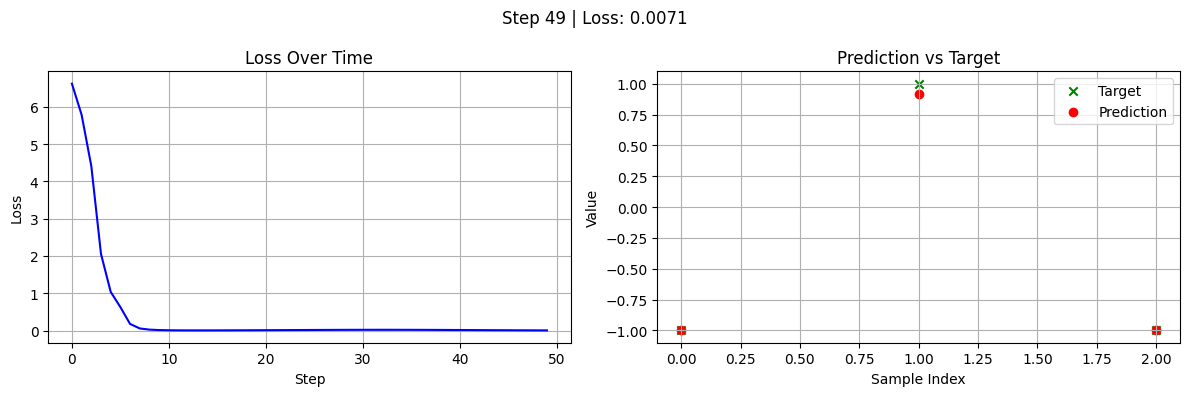

In [155]:
losses = []
filenames = []

for step in range(50):
    # Forward pass
    y_pred = [mlp(indv_x) for indv_x in x]

    # Loss evaluation
    Loss = sum([(yhat - yi)**2 for yi, yhat in zip(y, y_pred)])
    losses.append(Loss.data)  # Store scalar loss value

    # Backward pass
    Loss.backward()

    # Gradient Descent
    for params in mlp.parameters():
        params.data += - lr * params.grad

    # Print step and loss
    print(f"Step: {step} | Loss: {Loss}")

    # Live plot
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(losses, label="Loss", color='blue')
    ax1.set_title("Loss Over Time")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Plot predictions vs targets
    pred_vals = [yp.data for yp in y_pred]
    true_vals = [yt for yt in y]
    ax2.scatter(range(len(y)), true_vals, label="Target", marker='x', color='green')
    ax2.scatter(range(len(y_pred)), pred_vals, label="Prediction", color='red')
    ax2.set_title("Prediction vs Target")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Value")
    ax2.legend()
    ax2.grid(True)

    # Save loss plot
    fig_loss, ax_loss = plt.subplots()
    ax_loss.plot(losses, label="Loss", color='blue')
    ax_loss.set_title("Loss Over Time")
    ax_loss.set_xlabel("Step")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(True)
    fig_loss.tight_layout()
    fig_loss.savefig(f"loss-imgs/loss-over-time/loss_step_{step}.png")
    plt.close(fig_loss)

    # Save prediction vs target plot
    fig_pred, ax_pred = plt.subplots()
    ax_pred.scatter(range(len(y)), true_vals, label="Target", marker='x', color='green')
    ax_pred.scatter(range(len(y_pred)), pred_vals, label="Prediction", color='red')
    ax_pred.set_title("Prediction vs Target")
    ax_pred.set_xlabel("Sample Index")
    ax_pred.set_ylabel("Value")
    ax_pred.legend()
    ax_pred.grid(True)
    fig_pred.tight_layout()
    fig_pred.savefig(f"loss-imgs/pred-vs-target/pred_step_{step}.png")
    plt.close(fig_pred)

    plt.suptitle(f"Step {step} | Loss: {Loss.data:.4f}")
    plt.tight_layout()
    plt.show()

In [156]:
from natsort import natsorted

def make_gif(image_folder, output_path, duration=0.3):
    images = []
    files = natsorted(os.listdir(image_folder))  # ensures correct order
    for filename in files:
        if filename.endswith(".png"):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_path, images, duration=duration)

# Create GIFs
make_gif("loss-imgs/loss-over-time", "loss_over_time.gif")
make_gif("loss-imgs/pred-vs-target", "pred_vs_target.gif")

c:\Users\sjasm\Documents\neural-nets\venv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":


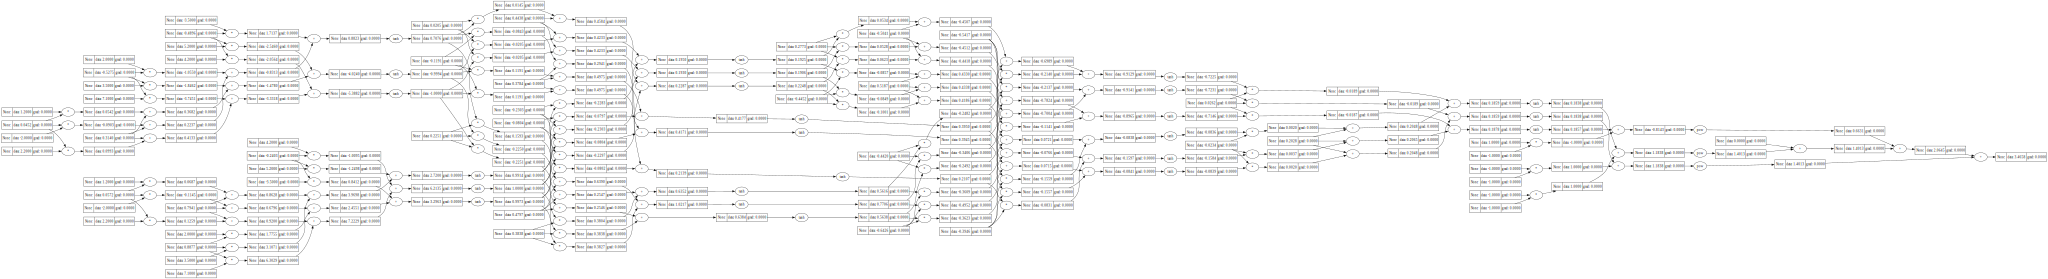

In [103]:
draw_dot(Loss)

In [104]:
Loss.backward()

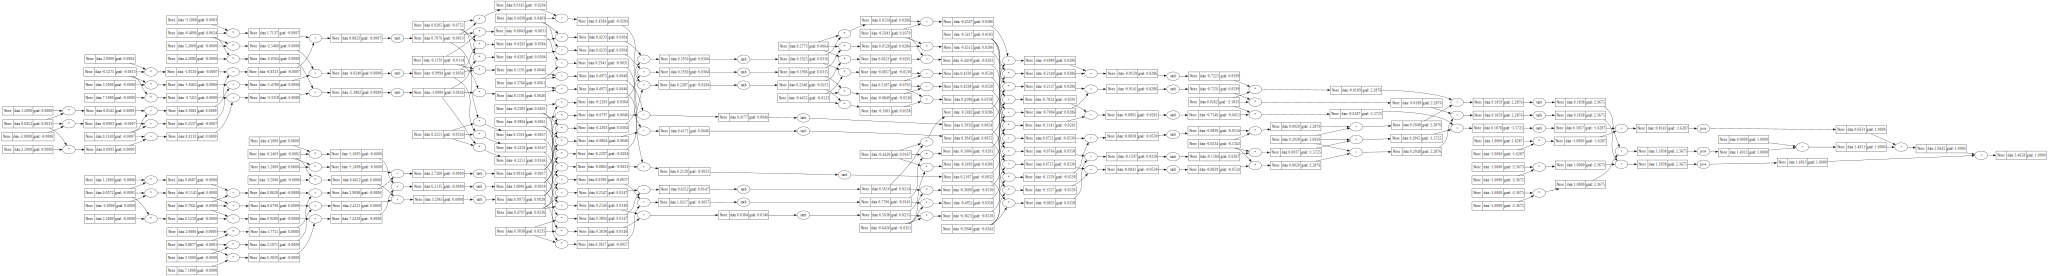

In [105]:
draw_dot(Loss)